# Analysis of HeartFailure database
- link: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction/data
- For practice, 3-5 simple comparisons of specific factors will be shown
- Implementing a simple multilpe linear regression model to produce a statistical table of how each factor may affect chances of attaining heart failure

## Note: been a few years since I've done biology so, anyone reading this with more knowledge in biology, feel free to  correct

- Implementing SQL as a way to easily store and retrieve data

In [150]:
import csv, datetime
import sqlite3, sqlalchemy
from contextlib import closing

import pandas as pd
import numpy as np
from pandas import Series, DataFrame

import seaborn as sb

import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, DateFormatter
import matplotlib.dates as mbd

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

In [151]:
# Opening a csv file and creating a DataFrame object from it
def file_to_DF(file_name, r_or_w, var_name):
    with open(file_name, r_or_w) as var_name:
        fileDF = pd.read_csv(var_name)
        return fileDF

In [152]:
heartFailure = file_to_DF("heart.csv", "r", "heartDF")
print(heartFailure)

     Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0     40   M           ATA        140          289          0     Normal   
1     49   F           NAP        160          180          0     Normal   
2     37   M           ATA        130          283          0         ST   
3     48   F           ASY        138          214          0     Normal   
4     54   M           NAP        150          195          0     Normal   
..   ...  ..           ...        ...          ...        ...        ...   
913   45   M            TA        110          264          0     Normal   
914   68   M           ASY        144          193          1     Normal   
915   57   M           ASY        130          131          0     Normal   
916   57   F           ATA        130          236          0        LVH   
917   38   M           NAP        138          175          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0      172              N  

# Data Cleaning
- Checking for null values
  - No null values present in the heart failure dataset

In [153]:
# checking for null values
hcol = [col for col in heartFailure.columns]
is_null = heartFailure[hcol].isna()
sum_is_null = is_null.sum()
print(hcol)
print(sum_is_null)
"""
No null values present 
"""

['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


'\nNo null values present \n'

# Creating an SQLite database

database = 'HeartFailure_v1.db'

with closing(
    sqlite3.connect(
        database, detect_types=sqlite3.PARSE_DECLTYPES | sqlite3.PARSE_COLNAMES
    )
) as db_conn:
    with closing(db_conn.cursor()) as db_cursor:
        #heartFailure.to_sql('HeartFailure_Main', db_conn, if_exists = 'fail')
        x = db_cursor.execute("""SELECT name FROM sqlite_schema
                WHERE type = 'table'
                ORDER BY name
            """)
        for i in x:
            print(i)
    db_conn.commit()


# Executing queries, creating graphs

In [154]:
# opens and closes a database automatically, execute sql queries
def connect_to_db(db_name, sql_q, choice):  # choice = 'sql' (only execute sql queries) or 'dataframe' (convert queries into dataframes)
    with closing(
        sqlite3.connect(
            db_name, detect_types=sqlite3.PARSE_DECLTYPES | sqlite3.PARSE_COLNAMES
        )
    ) as db_conn:
        with closing(db_conn.cursor()) as db_cursor:
            if choice == 'sql':
                query = db_cursor.execute(sql_q)
                return [i for i in query]
            elif choice == 'dataframe':
                return pd.read_sql(sql_q, db_conn)
                
            
        db_conn.commit()

In [155]:
def scatter_graph(X_data, Y_data, xtitle, ytitle, title):
    fig, axes = plt.subplots(1, 1, figsize=(10, 10))  # creates the blank graph space to draw the graph on
    axes.scatter(X_data, Y_data)

    sb.regplot(x = X_data, y = Y_data)

    axes.set_title(title)
    axes.set_ylabel(ytitle)
    axes.set_xlabel(xtitle)


In [156]:
database = 'HeartFailure_v1.db'
print(hcol)
# outputting all available table names in the database
table_query = """
                SELECT name FROM sqlite_schema
                WHERE type = 'table'
                ORDER BY name
            """
table_data = connect_to_db(database, table_query, 'sql')
print(table_data)

['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']
[('HeartFailure_Main',)]


## Comparisons to make
1) Comparing gender differences in cholesterol levels and heart disease
   - Graph 1 (scatter): Male, x = Age, y = cholesterol levels, HeartDisease = 1
   - Graph 2 (scatter): Female, x = Age, y = cholesterol levels, HeartDisease = 1
   - Graph 3 (histogram): two separate histograms showing cholesterol level distribution for each gender

2) Comparing RestingBP and MaxHR
   - Graph 1 (scatter): x = RestingBP, y = MaxHR
   - Graph 2 (histogram): distribution of resting BP
   - Graph 3 (histogram): distribution of MaxHR 

## Linear Regression model
- Creating a model which compares RestingBP, MaxHR, Cholesterol and Age, with HeartDisease as the classifying parameter

### 1) Gender, chol levels

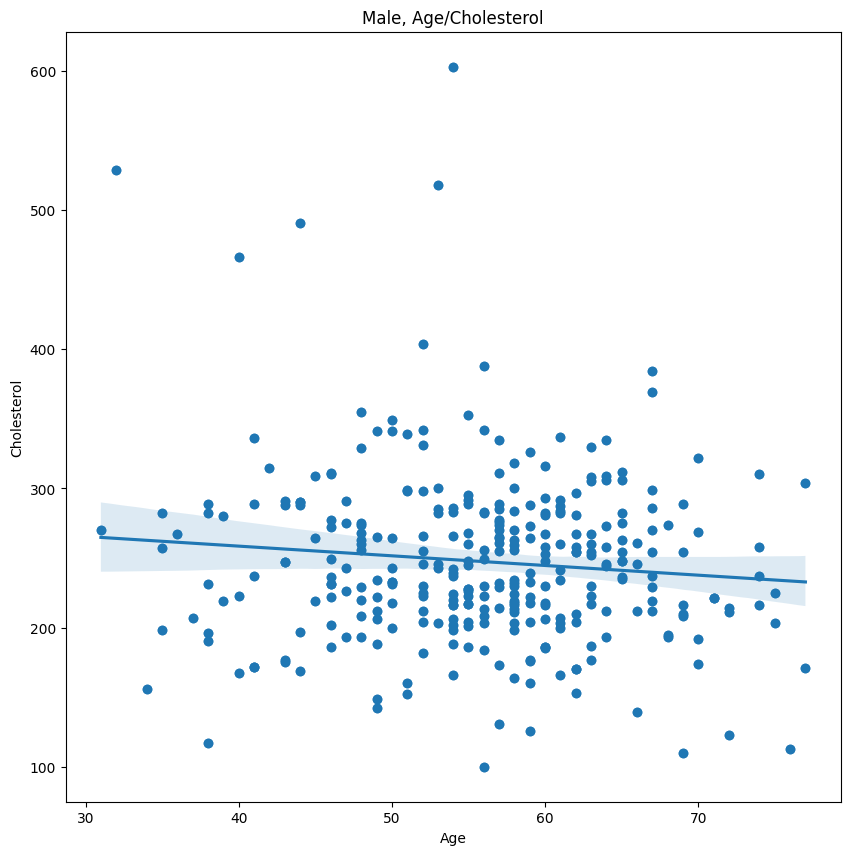

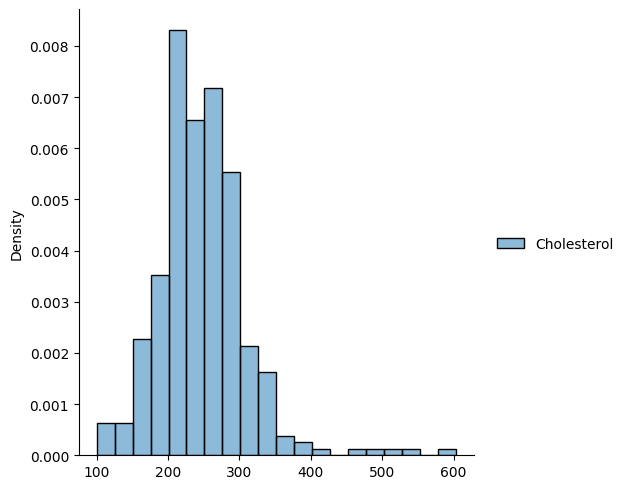

In [157]:
# Male
m_chol_hd = """
            SELECT Age, Cholesterol FROM HeartFailure_main 
            WHERE HeartDisease = 1 AND Sex = 'M'
            """

mx_age = """
            SELECT Age FROM HeartFailure_main
            WHERE HeartDisease = 1 AND Sex = 'M' AND (Cholesterol > 0)
        """
my_chol = """
            SELECT Cholesterol FROM HeartFailure_main
            WHERE HeartDisease = 1 AND Sex = 'M' AND (Cholesterol > 0)
         """
mx = connect_to_db(database, mx_age, 'dataframe')
my = connect_to_db(database, my_chol, 'dataframe')
#print(connect_to_db(database, m_chol_hd))
scatter_graph(mx, my, 'Age', 'Cholesterol', 'Male, Age/Cholesterol')
sb.displot(data = my, bins = 20, stat = 'density')

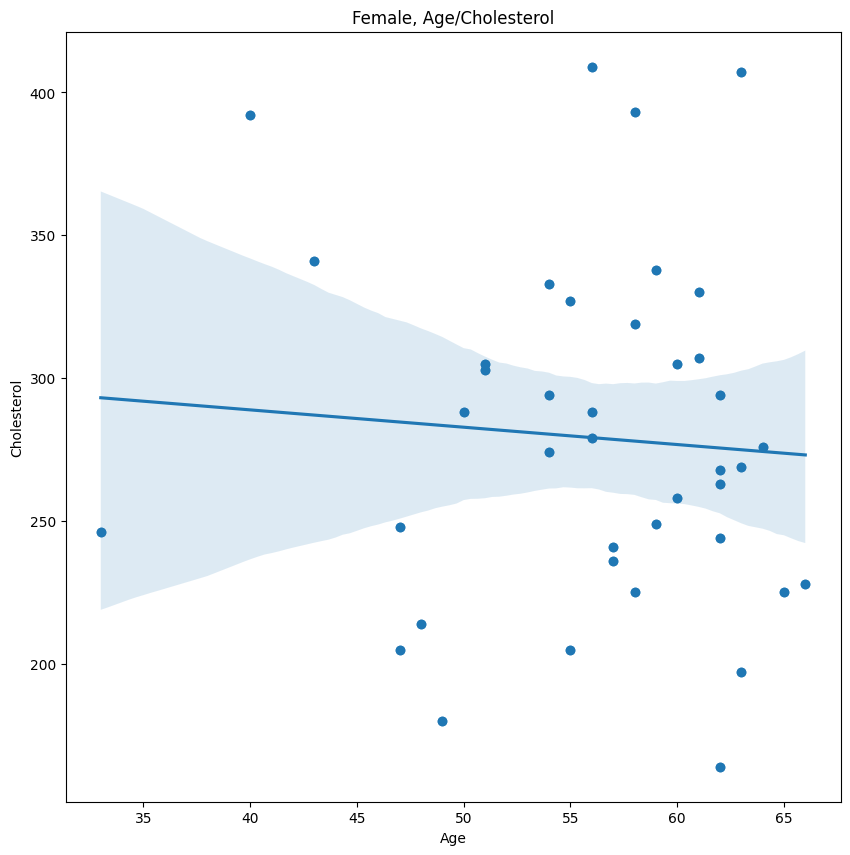

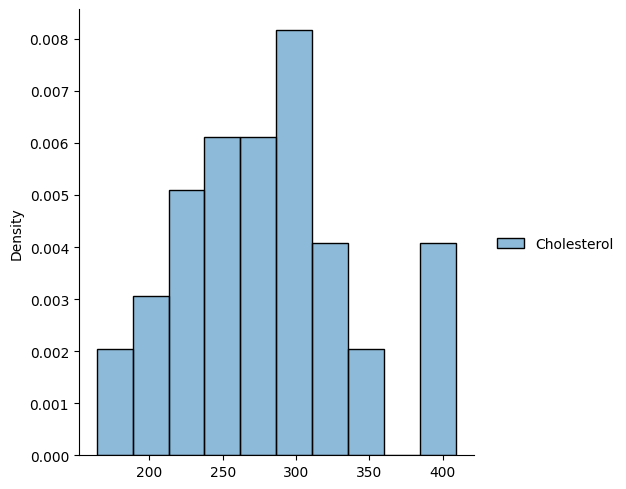

In [158]:
# Female
fx_age = """
            SELECT Age FROM HeartFailure_main
            WHERE HeartDisease = 1 AND Sex = 'F' AND (Cholesterol > 0)
        """
fy_chol = """
            SELECT Cholesterol FROM HeartFailure_main
            WHERE HeartDisease = 1 AND Sex = 'F' AND (Cholesterol > 0)
         """
fx = connect_to_db(database, fx_age, 'dataframe')
fy = connect_to_db(database, fy_chol, 'dataframe')
#print(connect_to_db(database, m_chol_hd))
scatter_graph(fx, fy, 'Age', 'Cholesterol', 'Female, Age/Cholesterol')
sb.displot(data = fy, bins = 10, stat = 'density')

### 2) RestingBP, MaxHR

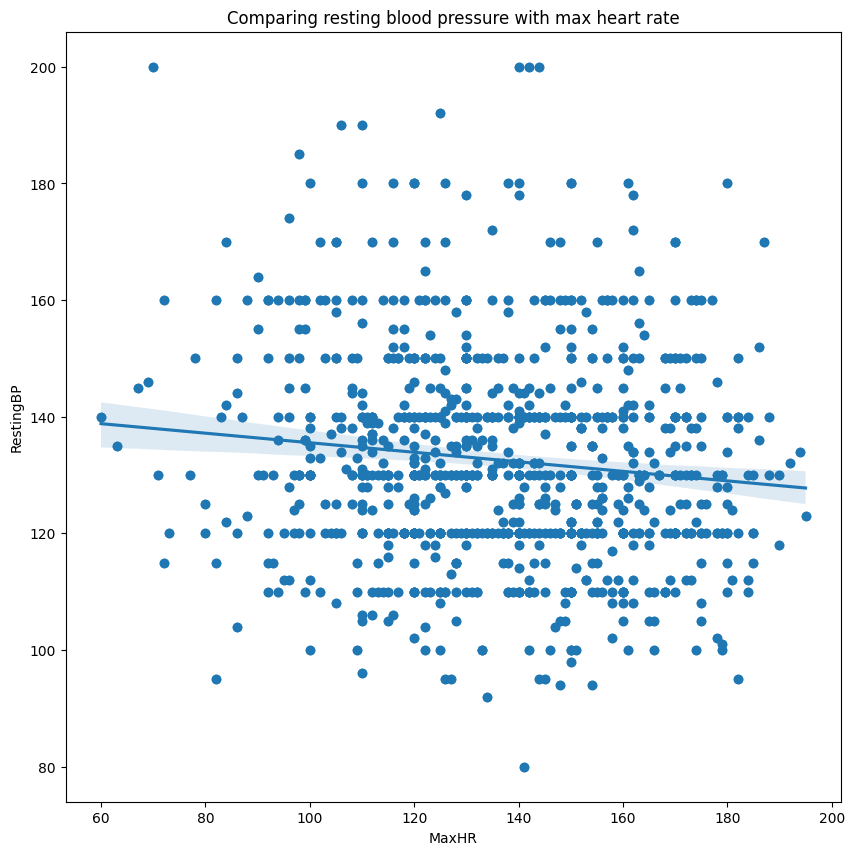

In [159]:
rest_bp = """
            SELECT RestingBP FROM HeartFailure_main
            WHERE RestingBP > 0
          """
max_hr  = """
            SELECT MaxHR FROM HeartFailure_main
            WHERE MaxHR < 200
          """
y_restbp = connect_to_db(database, rest_bp, 'dataframe')
x_maxhr = connect_to_db(database, max_hr, 'dataframe')
scatter_graph(x_maxhr, y_restbp, 'MaxHR', 'RestingBP', 'Comparing resting blood pressure with max heart rate')

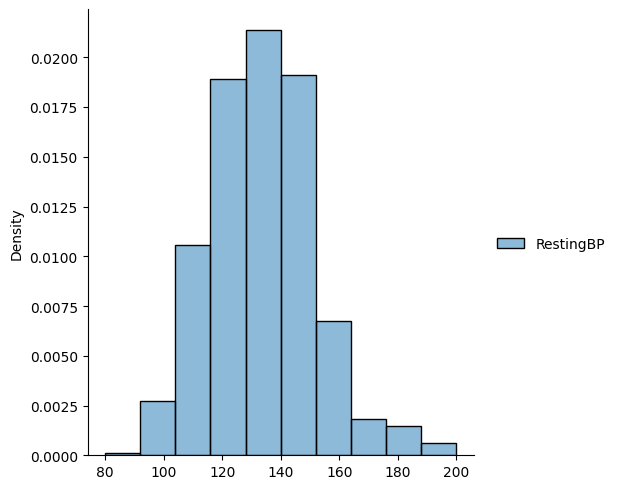

In [160]:
sb.displot(data = y_restbp, bins = 10, stat = 'density')

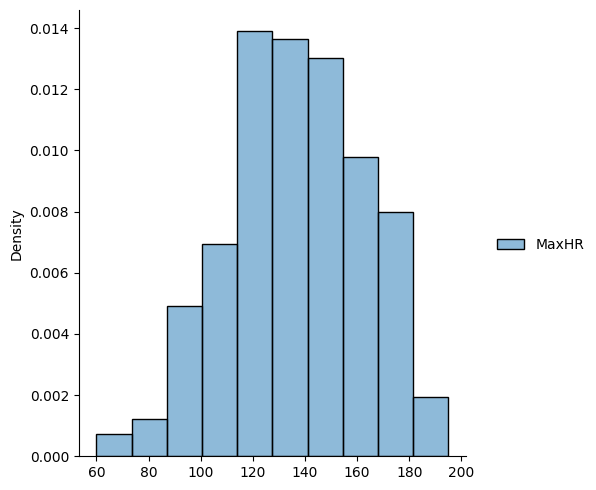

In [161]:
sb.displot(data = x_maxhr, bins = 10, stat = 'density')

# Linear regression model (4 quantitative, 1 qualitative)
Note: only using the raw dataframe. Will figure out how to use data from the database exclusively later

In [162]:
# Graph function for plotting the linear regresison plot
def abline(ax, b_int, m_grad, *args, **kwargs):
    xlim =  ax.get_xlim()
    ylim = [m_grad * xlim[0] + b_int, m_grad * xlim[1] + b_int]
    ax.plot(xlim, ylim, *args, **kwargs)

## Creating the model matrix

In [163]:
''' Creating the model matrix
- Creating a matrix for predictors (exogenous matrix)
- Creatiing a matrix for response (endogenous matrix)
- Fitting both matrices into a model (for this project, using ordinary least squares method)
'''
X = pd.DataFrame({'intercept': np.ones(heartFailure.shape[0]),
                  'RestingBP': heartFailure['RestingBP'],
                  'HeartDisease': heartFailure['HeartDisease'],
                  'CholesterolLevels': heartFailure['Cholesterol'],
                  'Age': heartFailure['Age']})  # create an array filled with 1s -> fills the matrix with 1s equal to the number of rows in the dataframe
#print(X)

y = heartFailure['MaxHR']
model = sm.OLS(y, X)  # decribing the model
results =  model.fit()  # fitting the values to the model
print(output.summary())
print(output.params)  # outputs the coeffecients -> RestingBP (B1 = 0.002891), intercept (B0 = 0.170677)

                            OLS Regression Results                            
Dep. Variable:                  MaxHR   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     79.59
Date:                Thu, 24 Apr 2025   Prob (F-statistic):           5.86e-58
Time:                        14:07:27   Log-Likelihood:                -4136.5
No. Observations:                 918   AIC:                             8283.
Df Residuals:                     913   BIC:                             8307.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept           183.3023      6.10

## Diagnostic plots
- Finding outliers, high leverage values, interaction terms

In [164]:
# Residual Plot -> any sign of correlation indicates non linear relationships between certain predictors
vals = [VIF(X, i) for i in range(1, X.shape[1])]
vif = pd.DataFrame({'vif_value': vals},
                  index = X.columns[1:])
print(vif)

                   vif_value
RestingBP           1.092749
HeartDisease        1.144785
CholesterolLevels   1.080037
Age                 1.154702


## Linear regression using all the columns in the dataset

In [165]:
'''Creating the model matrix: FAILURE'''
cols = heartFailure.columns.drop('MaxHR')  # using MaxHR as y
X = cols.transform(heartFailure)  # creating the model matrix of X
y = heartFailure['MaxHR']
model2 = sm.OLS(y, X)  # defining the model
results2 = model2.fit()  # fitting the data to the model
print(results2.summary())


AttributeError: 'Index' object has no attribute 'transform'

# End of project
I could continue on with this project but, I don't want to carry on working on something I find boring. Any feedback, for what I could do better in the future, is much appreciated as projects like these, are only for me to apply what I've learnt, into practice. 
Definitely one thing I'll take into the future is to suck up my pride and use the custom libraries the ISLP provides until, I've gained enough understand to replicate those libraries myself. 